## Connect to sqlite database (if necessary)

In [3]:
#work with sqlite database

#import sqlite3

#conn = sqlite3.connect('database.sqlite')
#c = conn.cursor()
#artists = c.execute('''SELECT * FROM artists''').fetchall()

#conn.commit()
#conn.close()

## Connect to Postgres database

In [4]:
#import necessary modules

import psycopg2
import pandas as pd

#create connection
conn = psycopg2.connect('dbname=pitchfork_reviews')
cur = conn.cursor()

#execute simple commands
cur.execute("""
SELECT * FROM genres;
""")

genres = cur.fetchall()

## 1. Is there a statistical difference between 'metal' and 'jazz' music genres? 

The first step is to choose what genres to compare. 

In [5]:
#load cast genres into a dataframe
df_genres = pd.DataFrame(genres)

#check unique values in genres
df_genres[1].unique()

array(['electronic', 'metal', 'rock', None, 'rap', 'experimental',
       'pop/r&b', 'folk/country', 'jazz', 'global'], dtype=object)

Let's choose **metal** and **jazz** genres to see if there is a statistical difference within reviews.

In [6]:
#check how many data entries we have for each genre
df_genres[1].value_counts()

rock            9436
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
metal            860
folk/country     685
jazz             435
global           217
Name: 1, dtype: int64

### Create a dataframe for reviews scores for 'metal' genre

In [7]:
#make a query from Postgres database to retrieve review scores for 'metal' genre

cur.execute("""
SELECT reviews.reviewid, reviews.score, genres.genre FROM reviews
INNER JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genres.genre = 'metal';
""")

metal = cur.fetchall()
len(metal)

862

In [8]:
#cast query result into a dataframe
metal_df = pd.DataFrame(metal, columns=['id', 'score', 'genre'])

In [9]:
len(metal_df)

862

### It seems that there 2 more rows than unique values for metal genre (862 in database query vs. 860 in rows where genre is 'metal)

In [10]:
#check number of unique values in our dataframe
len(metal_df['id'].unique())

859

In [11]:
#see if the duplicates have all the same values for score columns
metal_df[metal_df.id==9460]

,id,score,genre
555,9460,7.8,metal
556,9460,7.8,metal
557,9460,7.8,metal
558,9460,7.8,metal


In [12]:
#drop duplicates

metal_df.drop_duplicates(subset ="id", 
                     keep='first', inplace = True) 

In [13]:
#check if we have just one value for id=9460
metal_df[metal_df.id==9460]

,id,score,genre
555,9460,7.8,metal


### Create a dataframe for reviews scores for 'jazz' genre

In [14]:
#make a query from Postgres database to retrieve review scores for 'jazz' genre

cur.execute("""
SELECT reviews.reviewid, reviews.score, genres.genre FROM reviews
INNER JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genres.genre = 'jazz';
""")

jazz = cur.fetchall()
len(jazz)

435

In [15]:
#cast query result into a dataframe
jazz_df = pd.DataFrame(jazz, columns=['id', 'score', 'genre'])

In [16]:
#check output
jazz_df.head()

,id,score,genre
0,22707,9.0,jazz
1,22664,8.0,jazz
2,22660,5.2,jazz
3,22639,8.7,jazz
4,22652,7.0,jazz


In [17]:
#check for id duplicates 
len(jazz_df['id'].unique())

435

In [18]:
#close connection to database

#conn.commit()
#conn.rollback()

### Hypothesis testing

To compare 'metal' and 'jazz' scores we will look at the means of these two groups. We will assume that confidence level is 95%.

**Null hypothesis**: there is no statistical difference between reviews scores for 'metal' and 'jazz' genres, that is, the difference in means is equal to 0

**Alternative Hypothesis**: there is difference between reviews scores for 'metal' and 'jazz' genres: the difference in means is not equal to 0.

**Assumptions**:
- data is independent
- data collected randomely
- data is approximately normally distribuited

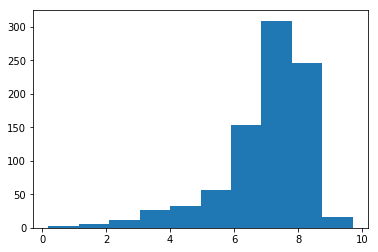

In [34]:
#check distribution of our data
import matplotlib.pyplot as plt

plt.hist(metal_df['score']);

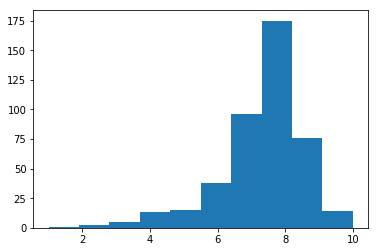

In [35]:
plt.hist(jazz_df['score']);

According to the plots of the distributions we can assume that data is approximately normally distribuited

In [19]:
#calculate the means for 2 groups

metal_mean = metal_df['score'].mean()
jazz_mean = jazz_df['score'].mean()
print('Mean for metal genre is: ', metal_mean)
print('Mean for jazz genre is: ', jazz_mean)

Mean for metal genre is:  6.9470314318975515
Mean for jazz genre is:  7.303908045977015


In [20]:
diff_means = metal_mean - jazz_mean
print('Difference in means is: ', diff_means)

Difference in means is:  -0.3568766140794635


In [21]:
#import fnctions module to compute t-statistic
import functions

t_stat = functions.twosample_tstatistic(metal_df['score'], jazz_df['score'])
t_stat                                                        

-4.5106654344463575

In [25]:
from scipy import stats

#calculate t-test statistic and p-value using scipy library
t_stat_check, p_value = stats.ttest_ind(metal_df['score'], jazz_df['score'])

In [23]:
t_stat_check

-4.510665434446266

In [26]:
p_value

7.0494843399548315e-06

In [27]:
#compare p-value with alpha/2, since we are doing 2-tailed test
print(p_value < 0.05/2)

True


### Conclusion

P-value is very small in our case which indicates that given null hypothesis is true, the probability that the results from the data we have would be due to a random chance. The probability of that is small enough to be able to reject the null hypothesis. So we can reject the null hypothesis and say that there is difference between review scores of 'metal' genre and 'jazz' genre.

## How independent are the samples? If the same person does the review, does he/she have bias towards metal or jazz genre?